# Import Dependencies

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

#Loading the Data

In [ ]:
# Step 1: Extract the ZIP file
zip_path = "pd_augmented_data.zip"  # Path to the zip file
extract_path = "./data"  # Directory where data will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Define paths
data_dir = os.path.join(extract_path, "augmented_data")
print(f"Data extracted to: {data_dir}")



Data extracted to: ./data/augmented_data


In [ ]:
# Step 3: Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Step 4: Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Step 5: Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% training data
val_size = len(dataset) - train_size  # 20% validation data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 6: Create DataLoaders
batch_size = 32  # Adjust based on memory capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print dataset details
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Classes: ['augmented_healthy', 'augmented_parkinson']
Training samples: 802
Validation samples: 201


# Define the VGG19-INC Hybrid Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG19_INCEPTION(nn.Module):
    def __init__(self, num_classes):
        super(VGG19_INCEPTION, self).__init__()

        # Load pre-trained VGG19 model and extract features
        vgg19 = models.vgg19(pretrained=True)
        self.vgg19_features = vgg19.features

        # Batch Normalization after VGG19 feature extraction
        self.batch_norm = nn.BatchNorm2d(512)  # 512 channels from VGG19

        # Inception module
        self.inception = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),  # 1x1 convolution
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 3x3 convolution
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=5, padding=2),  # 5x5 convolution
            nn.ReLU(inplace=True),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Assuming input image size is 224x224
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        # VGG19 feature extraction
        x = self.vgg19_features(x)

        # Apply Batch Normalization after VGG19
        x = self.batch_norm(x)

        # Inception module
        x = self.inception(x)
        x = torch.flatten(x, start_dim=1)

        # Classification
        x = self.classifier(x)
        return x


#Initialize the Model

In [ ]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
num_classes = 2  # Binary classification (PD vs Healthy)
model = VGG19_INCEPTION(num_classes=num_classes)
model.to(device)
# Freeze initial VGG19 layers
for param in model.vgg19_features[:10].parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#Define Optimizer, Loss Function, and Scheduler

In [ ]:
# Define optimizer with differential learning rates
optimizer = optim.Adam([
    {'params': model.vgg19_features.parameters(), 'lr': 1e-4},
    {'params': model.inception.parameters(), 'lr': 1e-3},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])

# Define loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


#Define Data Transformations

In [ ]:
# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Training and Validation Loop

##Model with BatchNorm

In [ ]:
# Initialize history dictionaries
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

# Training and validation loop with history tracking
num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    # Validation phase
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_vgg19_inception_pd.pth")
        print("Model improved. Saving the model.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model after training
model.load_state_dict(torch.load("best_vgg19_inception_pd.pth"))
print("Best model loaded.")


Epoch 1/50, Train Loss: 0.8049, Val Loss: 0.5381, Val Acc: 0.7761
Model improved. Saving the model.
Epoch 2/50, Train Loss: 0.4923, Val Loss: 0.3507, Val Acc: 0.8507
Model improved. Saving the model.
Epoch 3/50, Train Loss: 0.3582, Val Loss: 0.7934, Val Acc: 0.7264
No improvement for 1 epochs.
Epoch 4/50, Train Loss: 0.3052, Val Loss: 3.3965, Val Acc: 0.6866
No improvement for 2 epochs.


##Model without BatchNorm

In [ ]:
import matplotlib.pyplot as plt

# Initialize history dictionaries
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

# Training and validation loop with history tracking
num_epochs = 20
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    # Validation phase
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_vgg19_inception_pd.pth")
        print("Model improved. Saving the model.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model after training
model.load_state_dict(torch.load("best_vgg19_inception_pd.pth"))
print("Best model loaded.")


#Plotting the Training History

In [ ]:
history

{'train_loss': [0.1305829338872662,
  0.10893662044635186,
  0.11565686597560461,
  0.15008685888292697,
  0.1386026325277411,
  0.09064671059604734,
  0.08069885228402339,
  0.0679311974762151],
 'val_loss': [0.15432872569986752,
  0.1421861004616533,
  0.11629294151706356,
  0.22717025876045227,
  0.35302926919289995,
  0.1356182965849127,
  0.22032166618321622,
  0.2199601230344602],
 'val_accuracy': [0.9651741293532339,
  0.9552238805970149,
  0.9800995024875622,
  0.9054726368159204,
  0.8955223880597015,
  0.9552238805970149,
  0.9402985074626866,
  0.9353233830845771]}

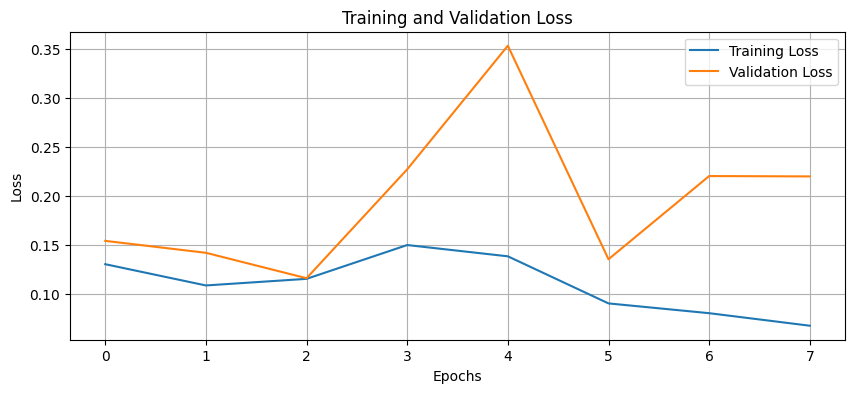

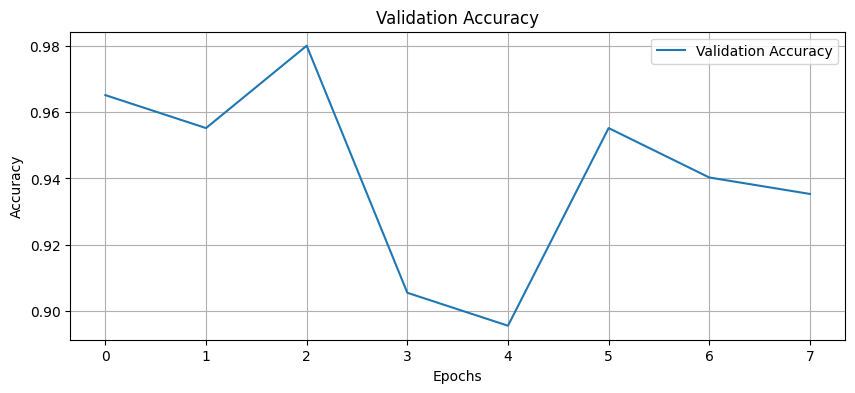

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


#LIME

In [ ]:
pip install lime

#Define a Wrapper for the Model

In [ ]:
from lime import lime_image
from torchvision.transforms.functional import normalize, resize, to_tensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Define the explanation function
def explain_with_lime(image_path, model, device, top_labels=2, num_features=5, num_samples=1000):
    # Define a model wrapper
    class ModelWrapper:
        def __init__(self, model):
            self.model = model
            self.model.eval()  # Set the model to evaluation mode

        def __call__(self, images):
            images = torch.stack([to_tensor(img).to(device) for img in images])
            images = normalize(images, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            outputs = self.model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().detach().numpy()

    # Instantiate the model wrapper
    model_wrapper = ModelWrapper(model)

    # Load and preprocess the image
    sample_image = Image.open(image_path).convert('RGB')
    sample_image_resized = resize(sample_image, [224, 224])

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate explanations
    explanation = explainer.explain_instance(
        np.array(sample_image_resized),  # Input image as numpy array
        model_wrapper,                   # Wrapped model
        top_labels=top_labels,           # Number of top classes to explain
        hide_color=0,                    # Background color for masked areas
        num_samples=num_samples          # Number of perturbed samples
    )

    # Visualize explanations for the top predicted class
    top_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label=top_class,
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )

    # Plot the explanation
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"Explanation for Class {top_class}")
    plt.axis('off')
    plt.show()




#Apply LIME to an Image

  0%|          | 0/1000 [00:00<?, ?it/s]

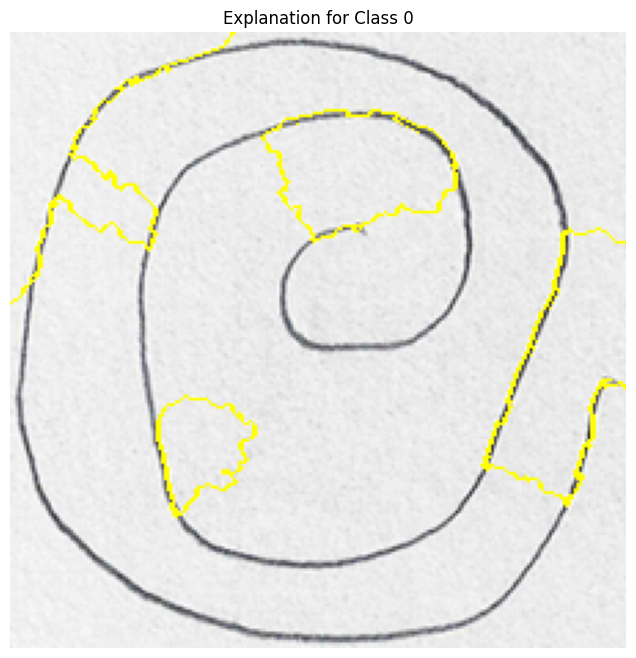

In [ ]:
# Example usage
explain_with_lime('/content/data/augmented_data/augmented_healthy/V01HE01.png', model, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

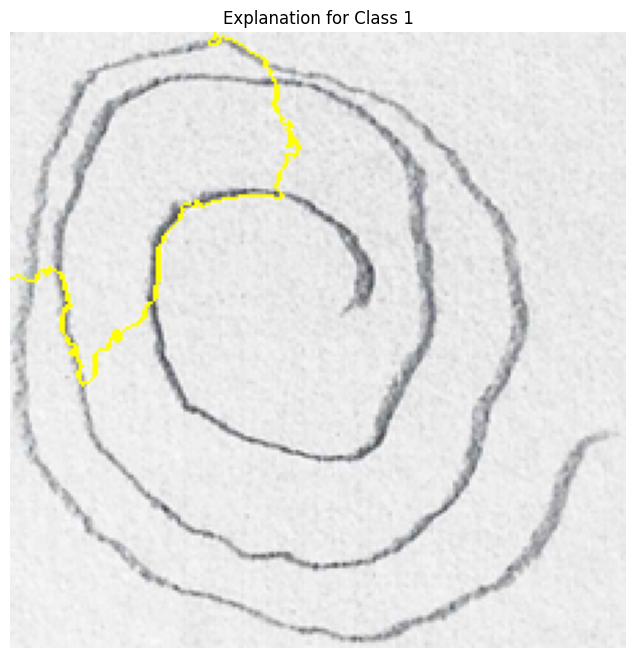

In [ ]:
explain_with_lime('/content/data/augmented_data/augmented_parkinson/V02PE01.png', model, device)


# SLICE

https://github.com/rebathip/SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification.git

In [1]:
!git clone https://github.com/rebathip/SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification.git

Cloning into 'SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 66 (delta 29), reused 16 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 1.16 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
!unzip pd_augmented_data.zip

Archive:  pd_augmented_data.zip
   creating: augmented_data/
  inflating: __MACOSX/._augmented_data  
   creating: augmented_data/augmented_healthy/
  inflating: augmented_data/.DS_Store  
  inflating: __MACOSX/augmented_data/._.DS_Store  
   creating: augmented_data/augmented_parkinson/
  inflating: augmented_data/augmented_healthy/aug_0_9528.jpg  
  inflating: augmented_data/augmented_healthy/V09HE02.png  
  inflating: __MACOSX/augmented_data/augmented_healthy/._V09HE02.png  
  inflating: augmented_data/augmented_healthy/aug_0_2858.jpg  
  inflating: augmented_data/augmented_healthy/V55HE06.png  
  inflating: __MACOSX/augmented_data/augmented_healthy/._V55HE06.png  
  inflating: augmented_data/augmented_healthy/V55HE12.png  
  inflating: __MACOSX/augmented_data/augmented_healthy/._V55HE12.png  
  inflating: augmented_data/augmented_healthy/aug_0_9058.jpg  
  inflating: augmented_data/augmented_healthy/aug_0_6551.jpg  
  inflating: augmented_data/augmented_healthy/aug_0_6974.jpg  
  i

In [3]:
def create_image_directory():
  # Create the directory if it doesn't exist
  if not os.path.exists('/content/images_pdh/'):
    os.makedirs('/content/images_pdh/')

  # Copy the specified files to the images directory
  shutil.copy('/content/augmented_data/augmented_healthy/V01HE01.png', '/content/images_pdh') #healthy
  shutil.copy('/content/augmented_data/augmented_parkinson/V03PE01.png', '/content/images_pdh') #pd

take the slice folder to the working directory

In [4]:
import shutil
import os

# Move the slice folder to /content
!mv /content/SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification/slice /content/


In [5]:
import os
import pickle
import numpy as np
import cv2
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
from skimage.segmentation import quickshift, mark_boundaries
from skimage.measure import regionprops
import copy
import random
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skimage import filters
import pandas as pd
import warnings
import tensorflow as tf
import pickle
import sys
from scipy.stats import kendalltau

from matplotlib import pyplot as plt
import time
from sklearn.utils import resample
from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity
import csv
from slice.slice_explainer import SliceExplainer
from slice.vit_img_classifier import ViTImageClassifier

In [6]:
create_image_directory()

In [7]:
def create_directory_and_file(directory):
  """Creates a directory and a file within it with specified content."""
  try:
    os.makedirs(directory, exist_ok=True)
    print(f"Directories '{directory}' created successfully.")
  except Exception as e:
    print(f"Error creating directory or file: {e}")


In [8]:
directory = '/content/results/pdh/slice_inceptionv3'


In [9]:
create_directory_and_file(directory)

Directories '/content/results/pdh/slice_inceptionv3' created successfully.


In [10]:
img_dir = "/content/images_pdh/"
try:
    img_filenames = os.listdir(img_dir)
except IndexError:
    print("No files found in the directory.")

algo_name = "slice"
results_dir = "/content/results/"
num_runs = 1
sample_size = 500
tol = 3 # tolerance parameter for feature elimination algorithm

In [11]:
model = tf.keras.applications.InceptionV3(weights='imagenet')
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
decode_predictions = tf.keras.applications.inception_v3.decode_predictions
target_img_size = (299, 299)

96112376/96112376 [==============================] - 5s 0us/step


In [12]:
model_name = model.name
model_name = model_name.replace("_", "")

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.segmentation
import skimage.color

In [17]:
def plot_segments(image_path, segments, pos_indices, neg_indices):
    # Load the image
    image = skimage.io.imread(image_path)
    image = skimage.transform.resize(image, (segments.shape[0], segments.shape[1]))

    # Create masks for positive and negative regions
    pos_mask = np.isin(segments, pos_indices)
    neg_mask = np.isin(segments, neg_indices)

    # Create overlays
    overlay = image.copy()
    overlay[pos_mask] = [1, 0, 0]  # Red for positive
    overlay[neg_mask] = [0, 0, 1]  # Blue for negative

    # Plot the original image, segments, and overlays
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(image, segments))
    ax[1].set_title("Segmented Image")
    ax[1].axis("off")

    ax[2].imshow(mark_boundaries(overlay, segments))
    ax[2].set_title("Highlighted Segments")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

In [18]:
img_filenames

['V03PE01.png', 'V01HE01.png']

In [19]:
imAge_directory= f"/content/images_pdh/{img_filenames[0]}"

In [20]:
imAge_directory

'/content/images_pdh/V03PE01.png'

In [28]:
num_runs=1

/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl
[0.12808718096481897, -0.017192785659874588, 0.052898577847074635, 0.997734911771071, 0.932149935585642, 0.658319183159511] non nan selected= 0.3
sel_sigma:0.3
V03PE01.png  :  38  :  500
******Non Zero Indices:  [9]
******Non Zero Indices:  [17 25]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7  3 35 29 36 34 23  1]
neg: [21 25 20 28 12 24 27 31 10 16 15  6 19 32  5 17 14]
V03PE01.png  :  38  :  500
******Non Zero Indices:  [ 9 26]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7  3 29 35 36 34 23  1]
neg: [21 25 20 28 24 12 27 10 31 16 15  6 19 32  5 17 14 18]
V03PE01.png  :  38  :  500
******Non Zero Indices:  [ 9 26]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non

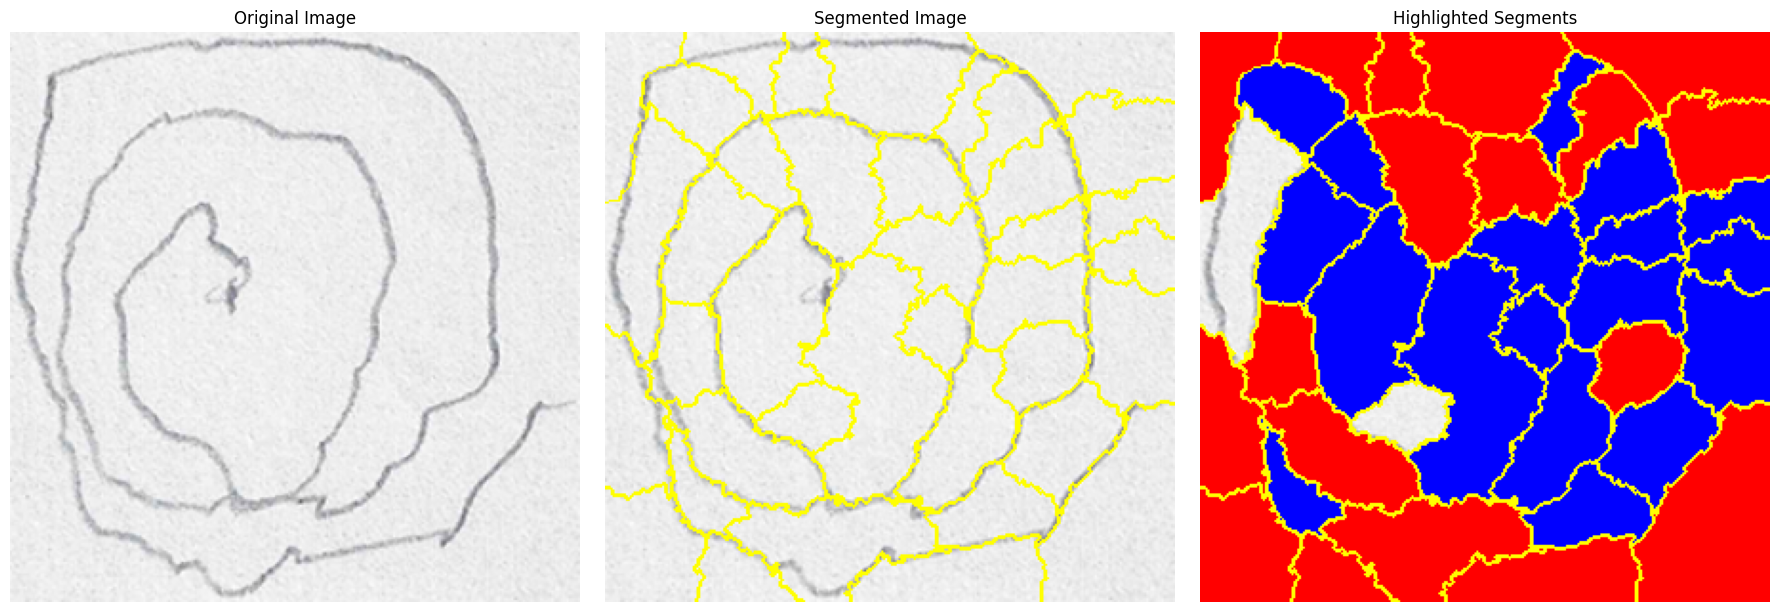

/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl
[0.06363097557536712, 0.05398816877262158, 0.021986222390809274, 0.9974745596311765, 0.9670986885581947, 0.8162525449207017] non nan selected= 0.3
sel_sigma:0.3
V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 43]
******Non Zero Indices:  [ 4 20]
******Non Zero Indices:  [32]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15  1 16 36 26 12  3 32 24 30  6 41  0 25  8 33]
neg: [38 28 18 37  5 19 14  7 11 27 39 22 13 29 17 31 44 34 40 42 10 23 20]
V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 21 35 43]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15 16  1 36 12 26  3 30 24 32  6 41  0 25  8 33  4]
neg: [38 28 18 37  5 19 14 11  7 27 39 22 13 29 17 31 44 34 40 42 10 23 20]
V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 35 43]
******Non Zero Indi

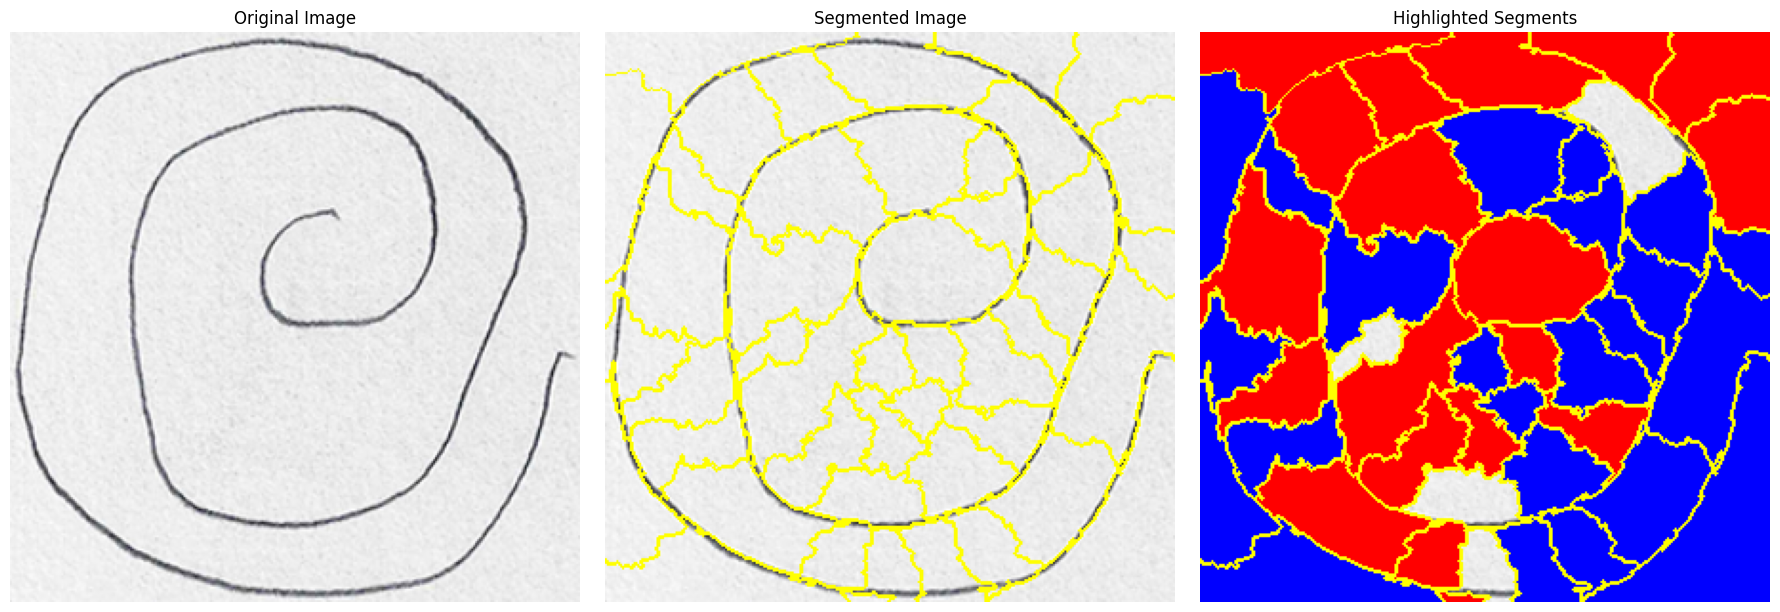

In [32]:
for img_filename in img_filenames:
    img_dict = {}
    img_dir_name = (img_dir.split("_")[1]).split("/")[0]
    img_filename_split = (img_filename.split(".jpg") if ".jpg" in img_filename else img_filename.split(".png"))[0]

    pkl_filename = results_dir + img_dir_name + "/" + algo_name + "_" + model_name + "/" + img_dir_name + "_" + \
                   algo_name + "_" + img_filename_split + "_" + model_name + ".pkl"
    print(pkl_filename) # the sub-dir inside results_dir should be present


    seg_img = skimage.io.imread(img_dir + img_filename)
    seg_img = skimage.transform.resize(seg_img, target_img_size)
    # too many segments will increase the computation time
    segments = skimage.segmentation.quickshift(seg_img, kernel_size=5, max_dist=200, ratio=0.2)
    exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                         target_img_size=target_img_size, preprocess=preprocess_input)
    sel_sigma = exp.select_sigma() # normally 0.3 works in most cases
    del exp

    print("sel_sigma:" + str(sel_sigma))
    run_dict = {}
    for i in np.arange(0, num_runs, step=1):
        # image_path=img_dir + img_filename
        exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                             target_img_size=target_img_size, preprocess=preprocess_input)
        print(img_filename, " : ", len(np.unique(exp.superpixels)), " : ", sample_size)
        unstable_features, pos_feature_ranks, neg_feature_ranks, num_samples_used, pos_dict, neg_dict\
            = exp.get_slice_explanations(num_perturb=sample_size, tolerance_limit=tol, sigma=sel_sigma,
                                         rank_stabilization=False)

        print("pos: " + str(pos_feature_ranks))
        print("neg: " + str(neg_feature_ranks))

        ranks = {'pos': pos_feature_ranks.tolist() if len(pos_feature_ranks) > 0 else np.array([]),
                 'neg': neg_feature_ranks.tolist() if len(neg_feature_ranks) > 0 else np.array([]),
                 'pos_dict': pos_dict, 'neg_dict': neg_dict, 'sel_sigma': sel_sigma,
                 'h_unstable': unstable_features, 'num_samples': num_samples_used}

        if f'run_{i}' not in run_dict:
            run_dict[f'run_{i}'] = []

        del exp
        #
        run_dict[f'run_{i}'].append(ranks)
        img_key = img_filename.split('.')[0]

    if f'run_{img_key}' not in img_dict:
        img_dict[f'run_{img_key}'] = []

    img_dict[f'run_{img_key}'].append(run_dict)

    # # save the selected feature ranks in a dict and save it in a pkl file
    print(pkl_filename)
    with open(pkl_filename, 'wb') as f1:
        pickle.dump(img_dict, f1)

    if len(ranks['pos'])>0 or len(ranks['neg'])>0:
          plot_segments(f"/content/images_pdh/{img_filename}", segments, ranks['pos'], ranks['neg'])


In [33]:
num_runs=3

/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl
[0.08129584875219142, 0.007628998244502583, 0.06956103557783899, 0.9975827861312216, 0.9440503968158882, 0.7735659850590685] non nan selected= 0.3
sel_sigma:0.3
V03PE01.png  :  38  :  500
******Non Zero Indices:  [26]
******Non Zero Indices:  [9]
******Non Zero Indices:  [17]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22 30  2  8 13  4  7 35  3 29 36 34 23  1]
neg: [21 25 20 28 24 12 27 31 10 16 15  6 19 32  5 17 14]


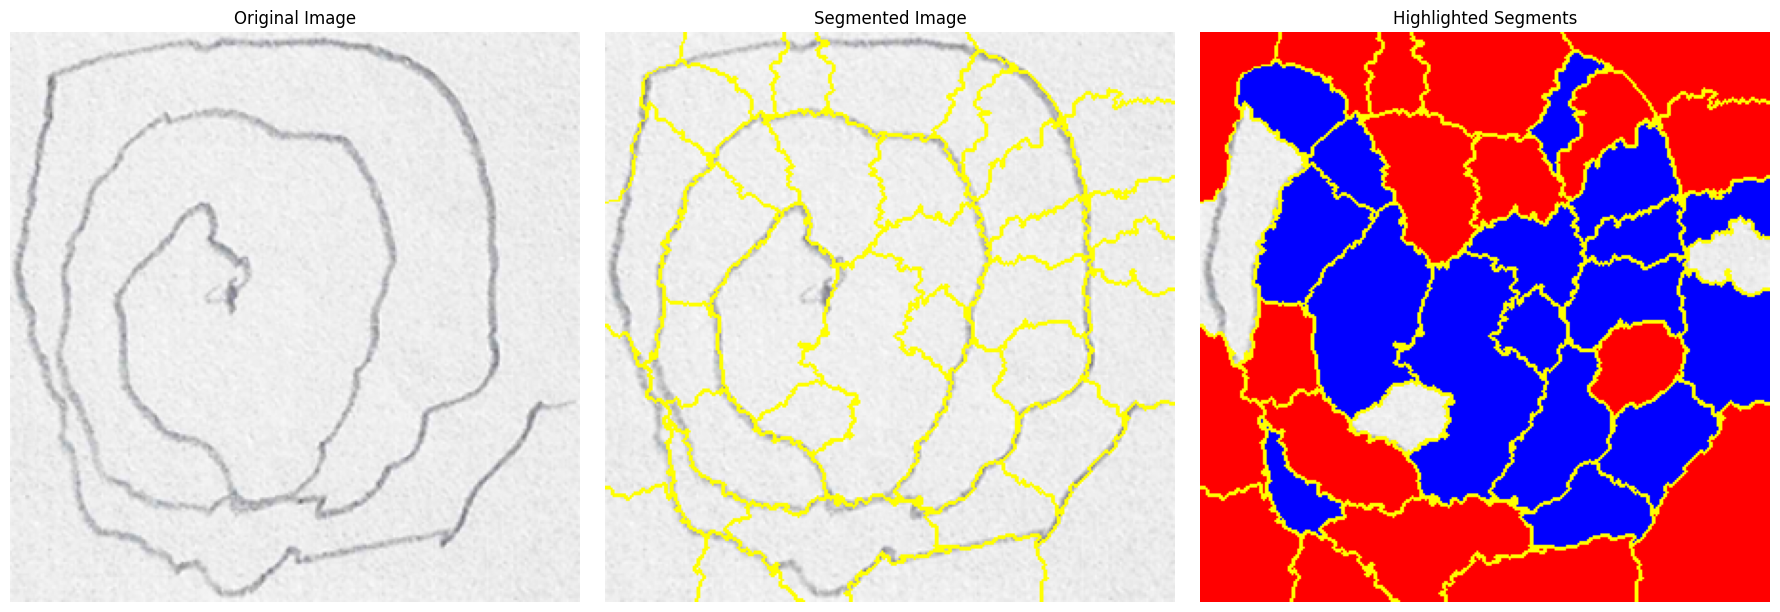

V03PE01.png  :  38  :  500
******Non Zero Indices:  [26]
******Non Zero Indices:  [18]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  [9]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7  3 35 29 36 23 34  1]
neg: [21 25 20 28 12 24 27 10 31 16 15  6 32 19  5 17 14]


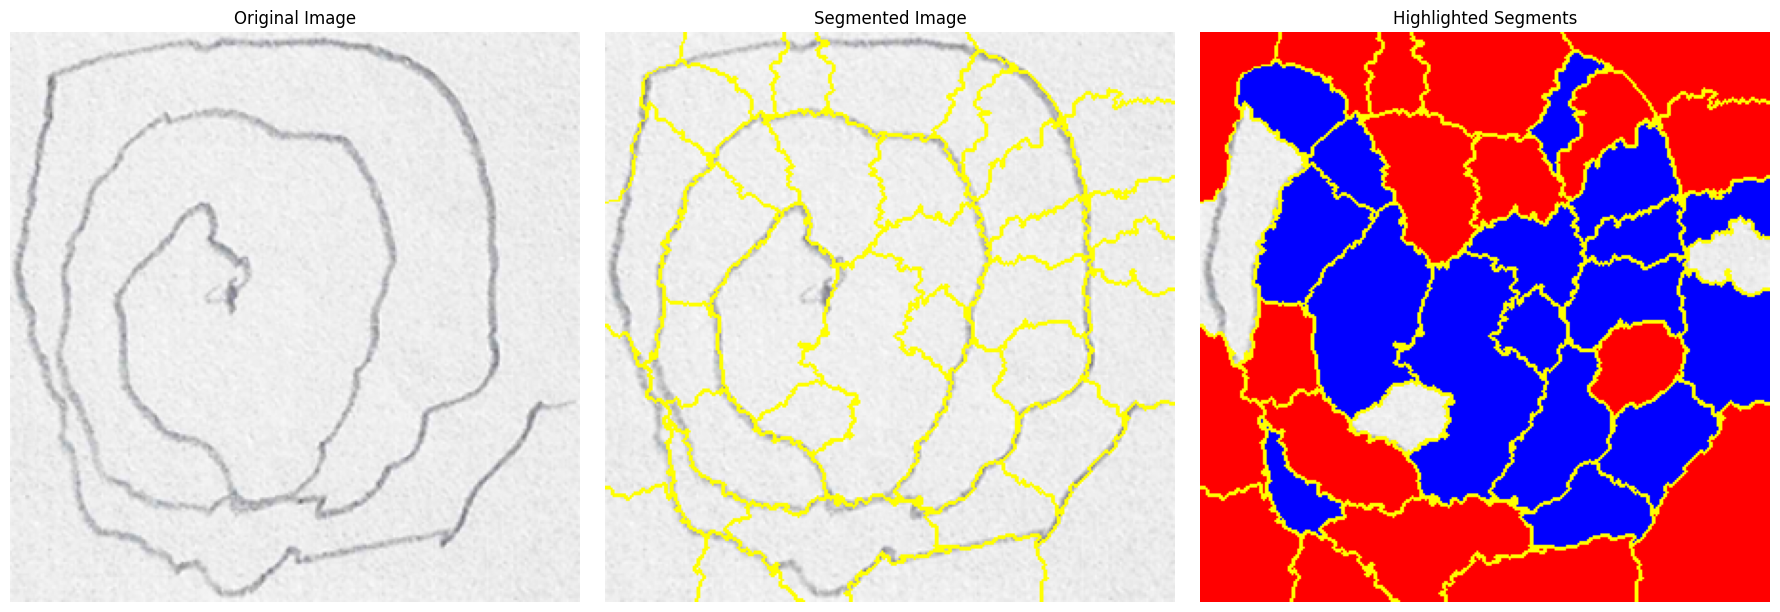

V03PE01.png  :  38  :  500
******Non Zero Indices:  [ 9 26]
******Non Zero Indices:  [17]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7 29  3 35 36 34 23  1]
neg: [21 25 20 28 24 12 27 31 10 16 15  6 19 32  5 17 14]


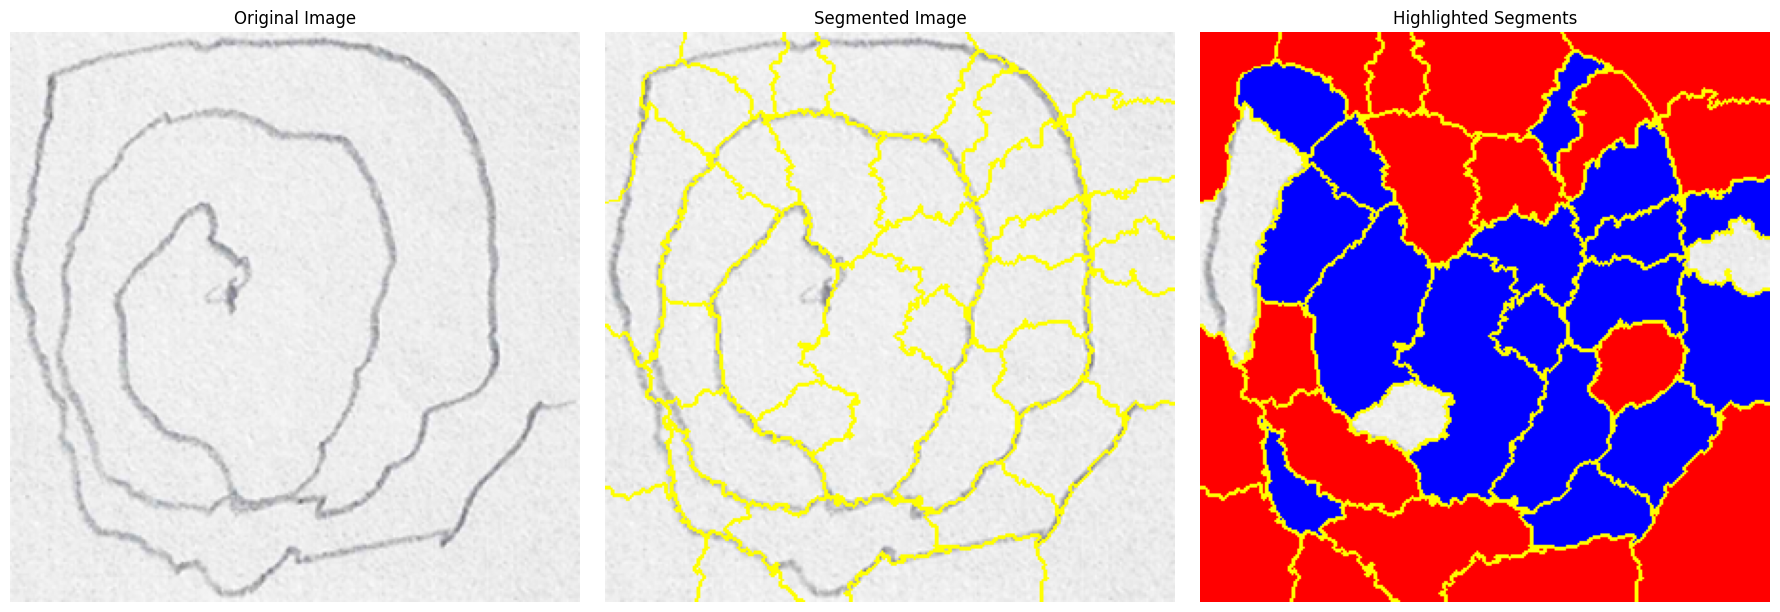

/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl
/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl
[0.05068269963437466, -0.000843219724265154, 0.057551093317004365, 0.9974475910300935, 0.9647684609088523, 0.8314081343650479] non nan selected= 0.3
sel_sigma:0.3
V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 21 35 43]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15 16  1 36 12 26  3 30 24 32  6 41  0 25  8 33  4]
neg: [38 28 18 37  5 19 14 11  7 39 22 27 13 29 31 17 44 34 40 42 10 23 20]


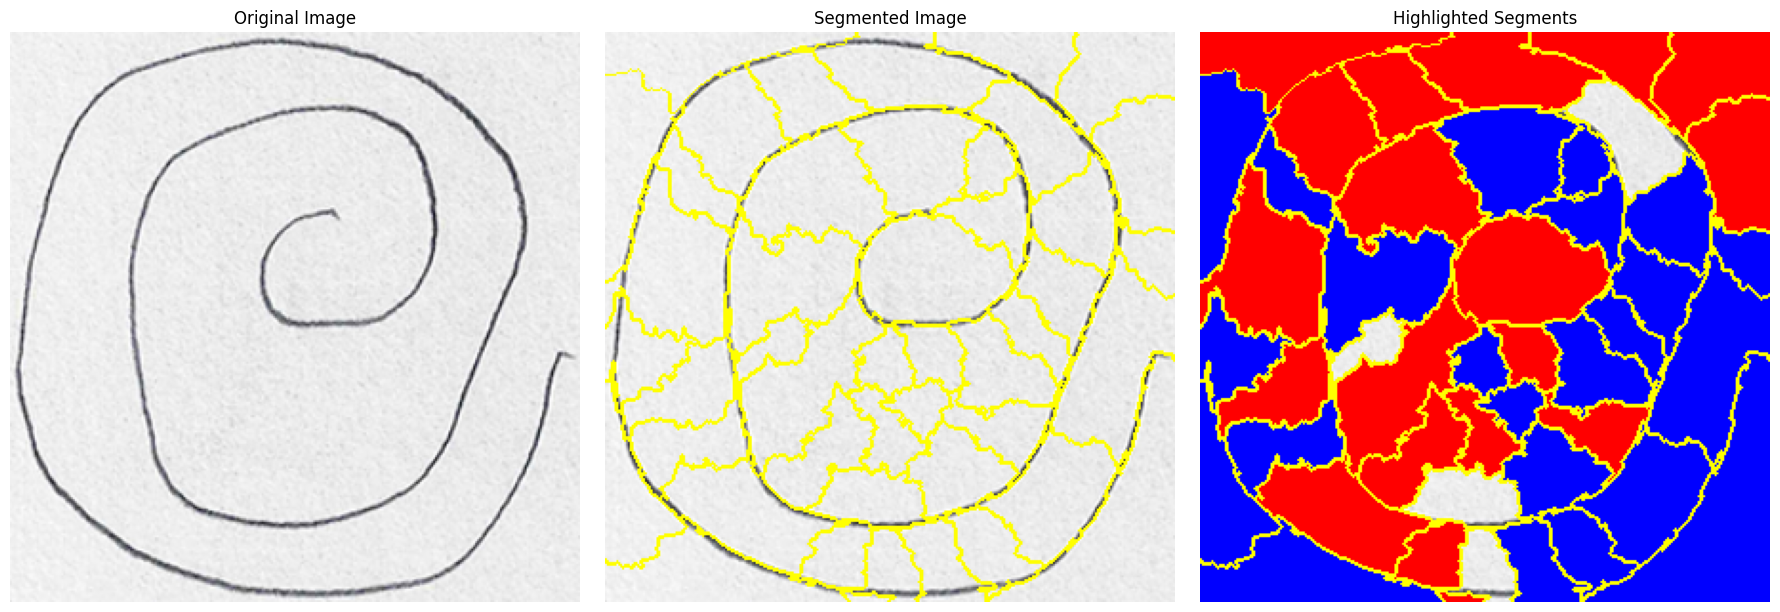

V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 21 35 43]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15  1 16 36 12 26  3 24 30 32  6 41  0 25  8 33  4]
neg: [38 28 18 37  5 19 14 11  7 27 39 22 13 29 17 31 44 40 34 42 10 23 20]


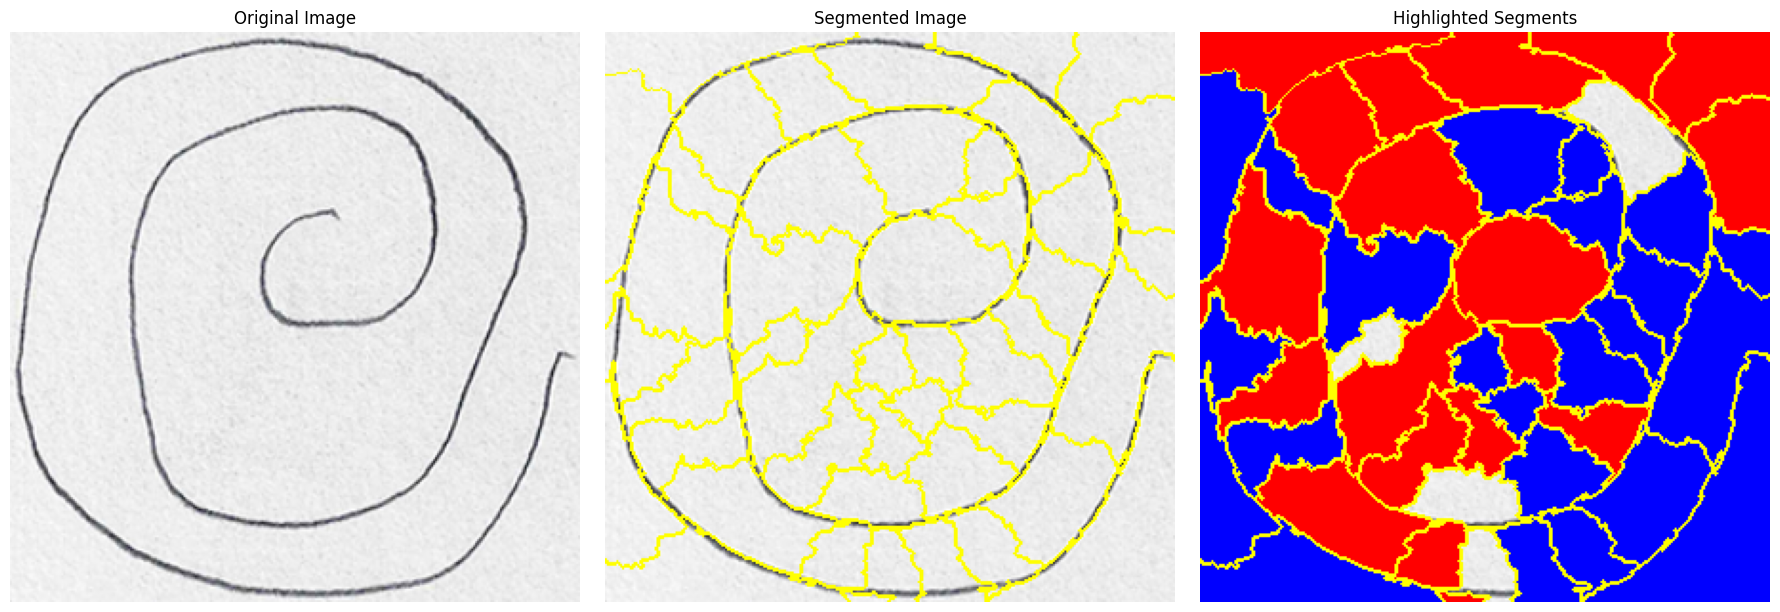

V01HE01.png  :  45  :  500
******Non Zero Indices:  [21 35 43]
******Non Zero Indices:  [9]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15 16  1 36 12 26  3 24 30 32  6 41  0 25  8  4 33]
neg: [38 28 18 37  5 19 14  7 11 39 27 22 13 29 31 17 44 34 40 42 23 10 20]


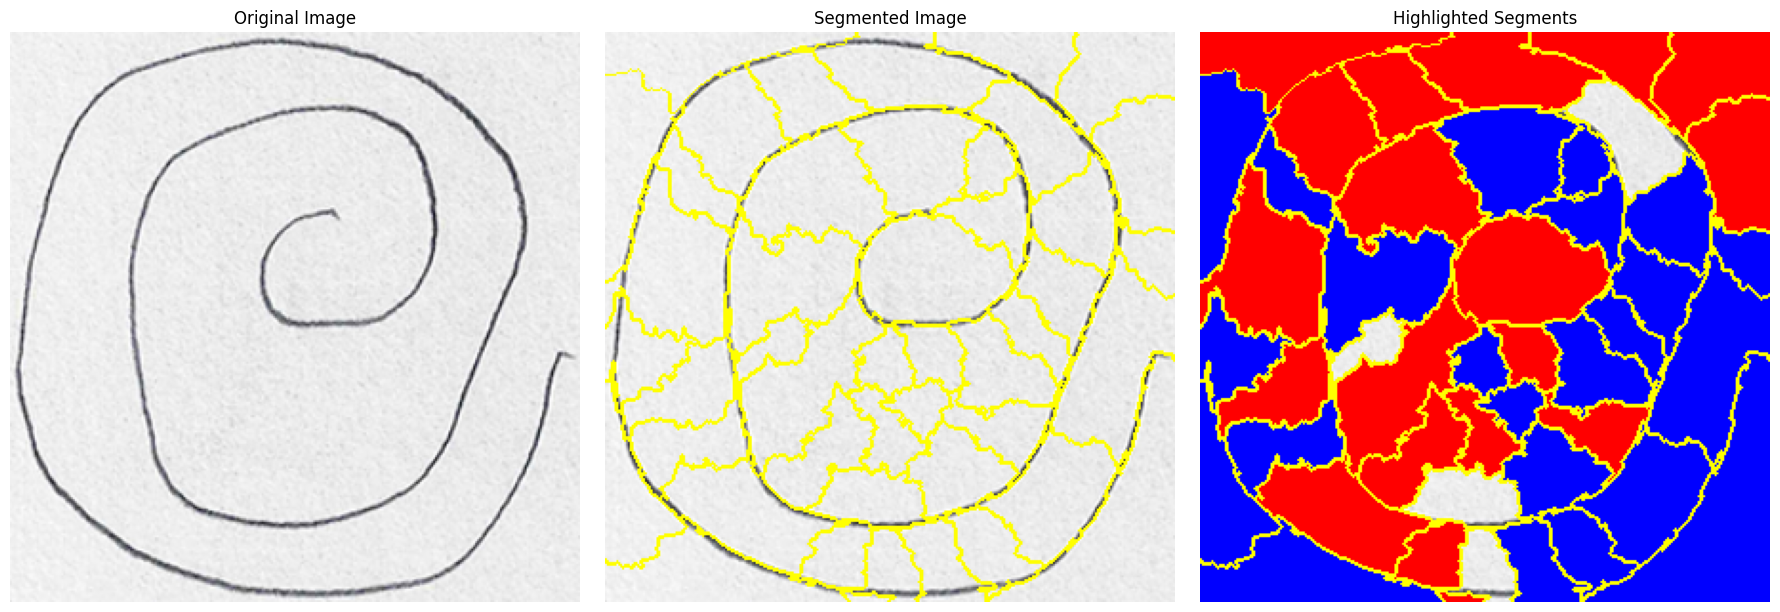

/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl


In [35]:
for img_filename in img_filenames:
    img_dict = {}
    img_dir_name = (img_dir.split("_")[1]).split("/")[0]
    img_filename_split = (img_filename.split(".jpg") if ".jpg" in img_filename else img_filename.split(".png"))[0]

    pkl_filename = results_dir + img_dir_name + "/" + algo_name + "_" + model_name + "/" + img_dir_name + "_" + \
                   algo_name + "_" + img_filename_split + "_" + model_name + ".pkl"
    print(pkl_filename) # the sub-dir inside results_dir should be present

    seg_img = skimage.io.imread(img_dir + img_filename)
    seg_img = skimage.transform.resize(seg_img, target_img_size)
    # too many segments will increase the computation time
    segments = skimage.segmentation.quickshift(seg_img, kernel_size=5, max_dist=200, ratio=0.2)
    exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                         target_img_size=target_img_size, preprocess=preprocess_input)
    sel_sigma = exp.select_sigma() # normally 0.3 works in most cases
    del exp

    print("sel_sigma:" + str(sel_sigma))
    run_dict = {}
    for i in np.arange(0, num_runs, step=1):
        # image_path=img_dir + img_filename
        exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                             target_img_size=target_img_size, preprocess=preprocess_input)
        print(img_filename, " : ", len(np.unique(exp.superpixels)), " : ", sample_size)
        unstable_features, pos_feature_ranks, neg_feature_ranks, num_samples_used, pos_dict, neg_dict\
            = exp.get_slice_explanations(num_perturb=sample_size, tolerance_limit=tol, sigma=sel_sigma,
                                         rank_stabilization=False)

        print("pos: " + str(pos_feature_ranks))
        print("neg: " + str(neg_feature_ranks))

        ranks = {'pos': pos_feature_ranks.tolist() if len(pos_feature_ranks) > 0 else np.array([]),
                 'neg': neg_feature_ranks.tolist() if len(neg_feature_ranks) > 0 else np.array([]),
                 'pos_dict': pos_dict, 'neg_dict': neg_dict, 'sel_sigma': sel_sigma,
                 'h_unstable': unstable_features, 'num_samples': num_samples_used}

        if f'run_{i}' not in run_dict:
            run_dict[f'run_{i}'] = []

        del exp
        #
        run_dict[f'run_{i}'].append(ranks)
        img_key = img_filename.split('.')[0]
        if len(ranks['pos'])>0 or len(ranks['neg'])>0:
          plot_segments(f"/content/images_pdh/{img_filename}", segments, ranks['pos'], ranks['neg'])
    if f'run_{img_key}' not in img_dict:
        img_dict[f'run_{img_key}'] = []

    img_dict[f'run_{img_key}'].append(run_dict)

    # # save the selected feature ranks in a dict and save it in a pkl file
    print(pkl_filename)
    with open(pkl_filename, 'wb') as f1:
        pickle.dump(img_dict, f1)


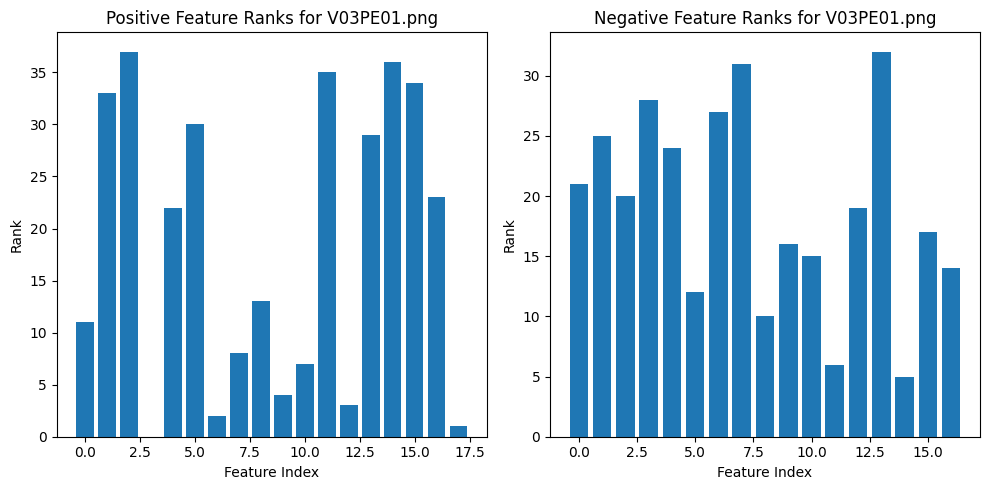

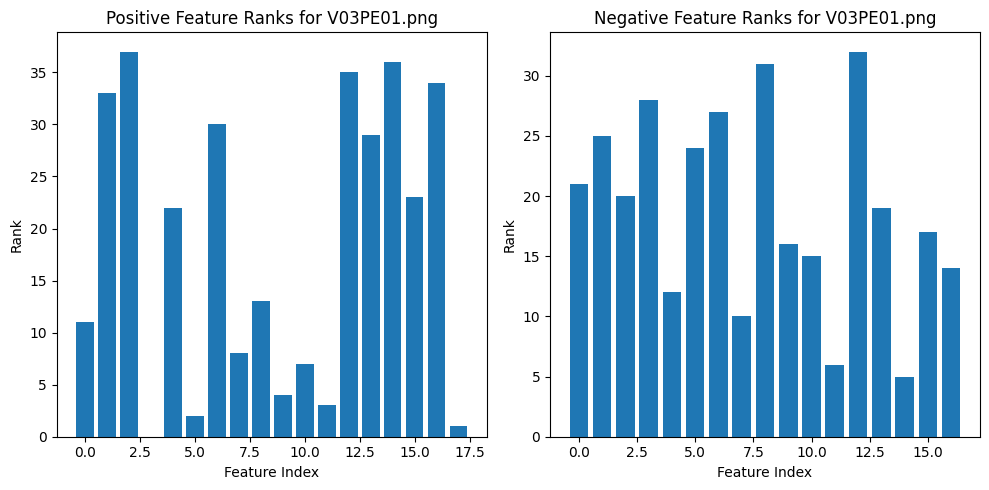

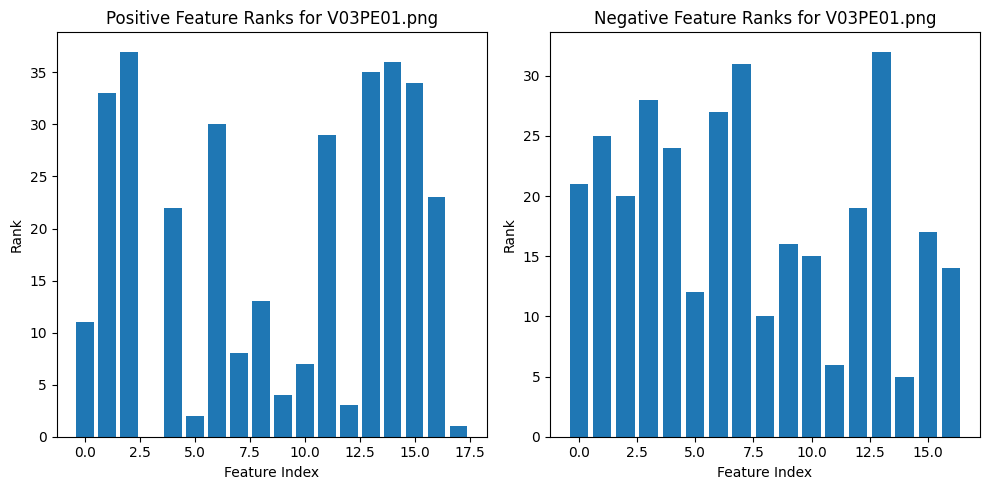

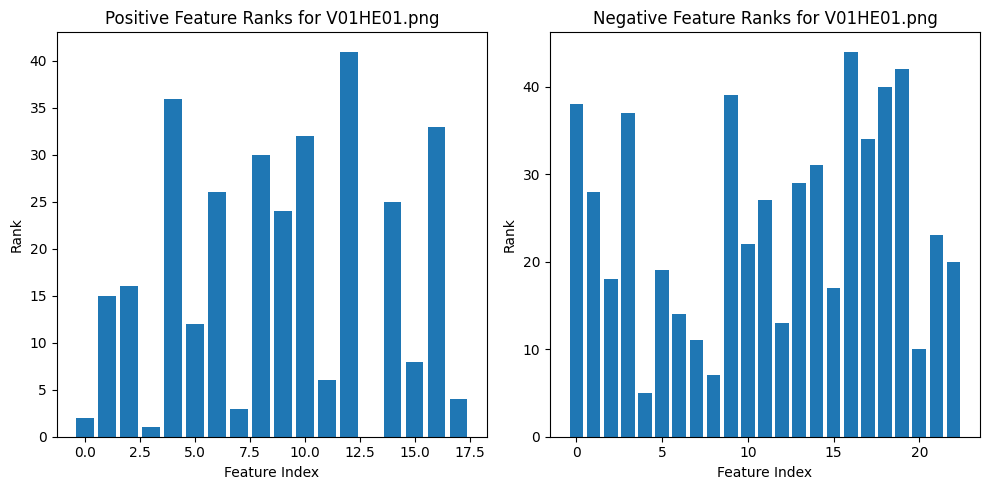

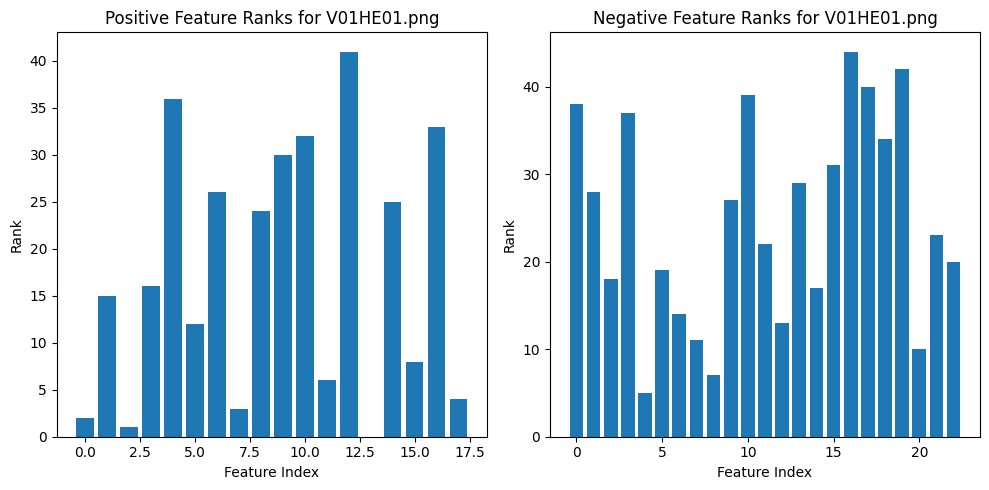

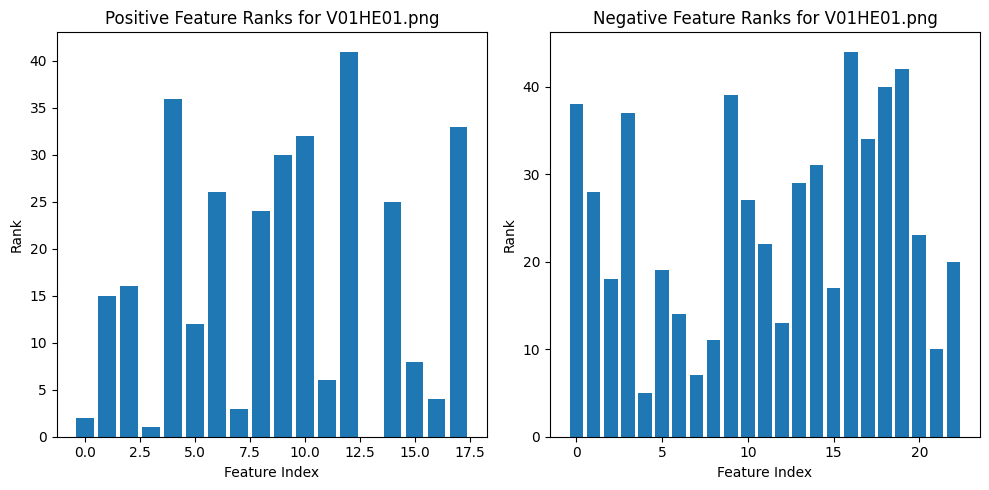

In [42]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming 'results_dir' and other relevant variables are defined as in the original code.
results_dir = "/content/results/"  # Replace with your actual results directory
img_dir = "/content/images_pdh/"  # Replace with your actual image directory
img_filenames = os.listdir(img_dir)

# Function to plot positive and negative feature maps
def plot_feature_maps(pos_ranks, neg_ranks, img_filename):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(pos_ranks)), pos_ranks)
    plt.title(f"Positive Feature Ranks for {img_filename}")
    plt.xlabel("Feature Index")
    plt.ylabel("Rank")

    plt.subplot(1, 2, 2)
    plt.bar(range(len(neg_ranks)), neg_ranks)
    plt.title(f"Negative Feature Ranks for {img_filename}")
    plt.xlabel("Feature Index")
    plt.ylabel("Rank")

    plt.tight_layout()
    plt.show()

# Loop through pickle files and plot feature maps
for img_filename in img_filenames:
    pkl_filename = os.path.join(results_dir, "pdh", "slice_inceptionv3", f"pdh_slice_{img_filename.split('.')[0]}_inceptionv3.pkl")  # Adjust file path as needed

    if os.path.exists(pkl_filename):
      with open(pkl_filename, 'rb') as f:
          try:
              img_dict = pickle.load(f)
              # Assuming data structure (adapt as needed based on your actual pickle file content)
              for img_key, run_data in img_dict.items():
                for run_dict in run_data:
                  for run_key, ranks_list in run_dict.items():
                    pos_ranks = ranks_list[0]['pos']
                    neg_ranks = ranks_list[0]['neg']
                    plot_feature_maps(pos_ranks, neg_ranks, img_filename)
          except (EOFError, pickle.UnpicklingError) as e:
              print(f"Error loading pickle file '{pkl_filename}': {e}")
    else:
        print(f"Pickle file not found: {pkl_filename}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries
from skimage.io import imread
import skimage

def plot_segments(image_path, segments, pos_indices, neg_indices):
    # Load the image
    image = skimage.io.imread(image_path)
    image = skimage.transform.resize(image, (segments.shape[0], segments.shape[1]))

    # Create masks for positive and negative regions
    pos_mask = np.isin(segments, pos_indices)
    neg_mask = np.isin(segments, neg_indices)

    # Create overlays
    overlay = image.copy()
    overlay[pos_mask] = [1, 0, 0]  # Red for positive
    overlay[neg_mask] = [0, 0, 1]  # Blue for negative

    # Plot the original image, segments, and overlays
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(image, segments))
    ax[1].set_title("Segmented Image")
    ax[1].axis("off")

    ax[2].imshow(mark_boundaries(overlay, segments))
    ax[2].set_title("Highlighted Segments")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


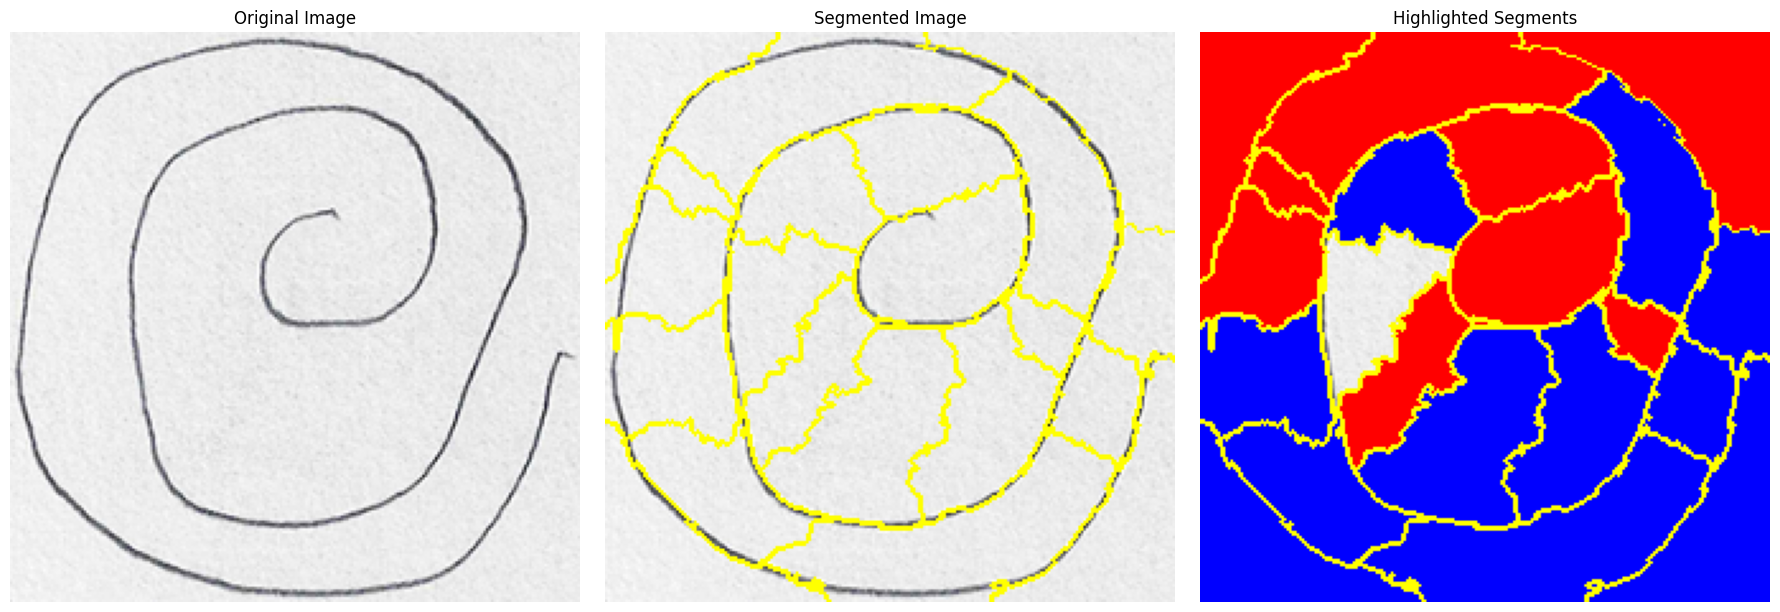

In [ ]:
# Corrected Example Usage
from skimage.io import imread
from skimage.segmentation import quickshift
from skimage.transform import resize

image_path = "/content/images_pdh/V01HE01.png"  # Replace with actual image path

# Load the image
image = imread(image_path)
image = resize(image, (224, 224))  # Resize to a standard size if needed

# Perform segmentation
segments = quickshift(image, kernel_size=5, max_dist=200, ratio=0.2)

# Positive and Negative indices (example values)
pos_indices = [11, 33, 37, 0, 22, 2, 30, 8, 13, 4, 7, 35, 3, 29, 36, 34, 23, 1]
neg_indices = [21, 25, 20, 28, 12, 24, 27, 10, 31, 15, 16, 6, 19, 32, 5, 17, 14, 18]

# Call the plot function
plot_segments(image_path, segments, pos_indices, neg_indices)
